# Analyze (and create pretty images) of the reduced data

This is using the WCS images after running through astrometry.net

In [86]:
import os, glob

import matplotlib.pyplot as plt

from astropy.nddata import CCDData
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u

import ccdproc

from util import *

targ_coord = SkyCoord(
    "05:26:38.320",
    "-17:54:54.68",
    unit=("hourangle", "deg")
)

In [13]:
wcs_data_path = os.path.join(os.getcwd(), "my-data", "calib", "*WCS*")
wcs_data_files = glob.glob(wcs_data_path)
wcs_data = [CustomCCDData.read(f) for f in wcs_data_files]

wcs_data

[CustomCCDData([[1570.76647366, 1367.56206004, 1547.44383164, ...,
                 1517.64719029, 1556.88588071, 1526.58906667],
                [1519.91308039, 1443.48840168, 1363.86784011, ...,
                 1336.75107136, 1349.49507742, 1456.32315174],
                [1544.66029908, 1369.79631303, 1387.78683337, ...,
                 1283.93690145, 1330.45730251, 1466.91393086],
                ...,
                [1312.40608325, 1164.89948906, 1109.45447982, ...,
                 1127.79033946, 1145.66687404, 1265.50469748],
                [1298.16641913, 1136.80177355, 1190.86091287, ...,
                 1161.90248182, 1162.9678884 , 1249.77911185],
                [1309.04853463, 1155.53961388, 1130.5572673 , ...,
                 1137.63316403, 1120.21176636, 1265.9951438 ]], unit='adu'),
 CustomCCDData([[893.94677335, 716.18846902, 886.80154954, ...,
                 843.52716163, 840.77739847, 891.54251045],
                [850.68637105, 743.35792668, 711.67935906, ..

Text(0.5, 0.01, 'Right Ascension')

/home/nfranz/.local/lib/anaconda3/lib/python3.11/site-packages/IPython/core/events.py:89: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  func(*args, **kwargs)


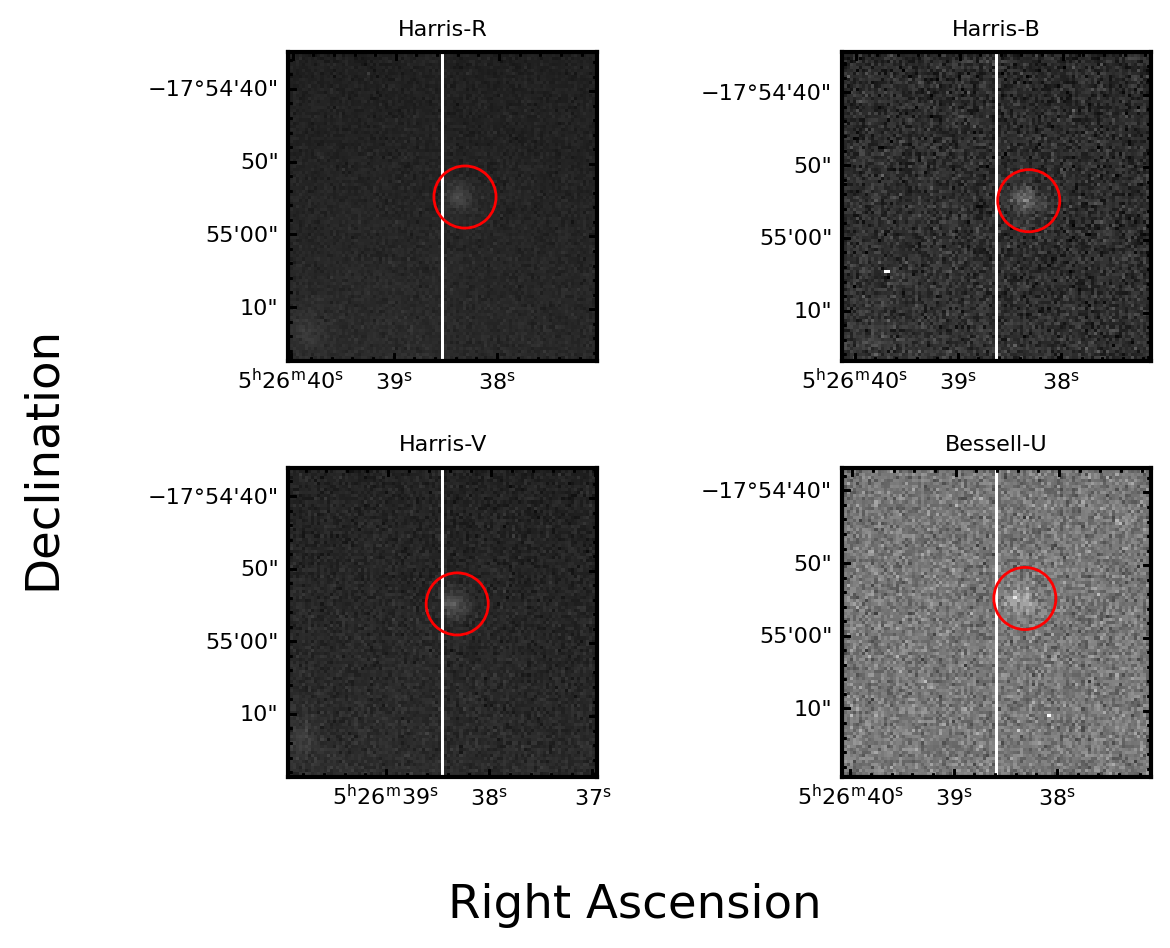

In [158]:
from matplotlib.colors import Normalize as Normalizer
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.visualization import simple_norm

fs = 8
ms = 500
fig = plt.figure()

dx = dy = 50
midx = img.data.shape[0]//2
midy = img.data.shape[0]//2 + 20
xlim = (midx-dx, midx+dx)
ylim = (midy-dy, midy+dy)

norm_kwargs = { # these are all from playing around in ds9
    "Harris-B" : dict(vmin=775, vmax=930),
    "Harris-R" : dict(vmin=1175, vmax=1787),
    "Harris-V" : dict(vmin=1140, vmax=1532),
    "Bessell-U" : dict(vmin=186, vmax=252)
}

for ii, img in enumerate(wcs_data):
    
    wcs = img.wcs
    ax = fig.add_subplot(2,2,ii+1,projection=wcs) 
    
    ax.imshow(
        img.data,
        origin="lower",
        norm=simple_norm(
            data=img.data,
            stretch="linear",
            **norm_kwargs[img.meta["FILTER"]]
        ),
        cmap="gray"
    )
    
    for coord in ax.coords._coords:
        coord.set_auto_axislabel(False)
        coord.tick_params(labelsize=fs)
    
    ax.scatter_coord(targ_coord, ms, edgecolor='r', facecolor="none")
    
    ax.set_title(img.meta["FILTER"], fontsize=fs)
    
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    
fig.supylabel("Declination")
fig.supxlabel("Right Ascension")

# turn these into a prettified color image

(652.0, 752.0)

/home/nfranz/.local/lib/anaconda3/lib/python3.11/site-packages/IPython/core/events.py:89: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  func(*args, **kwargs)


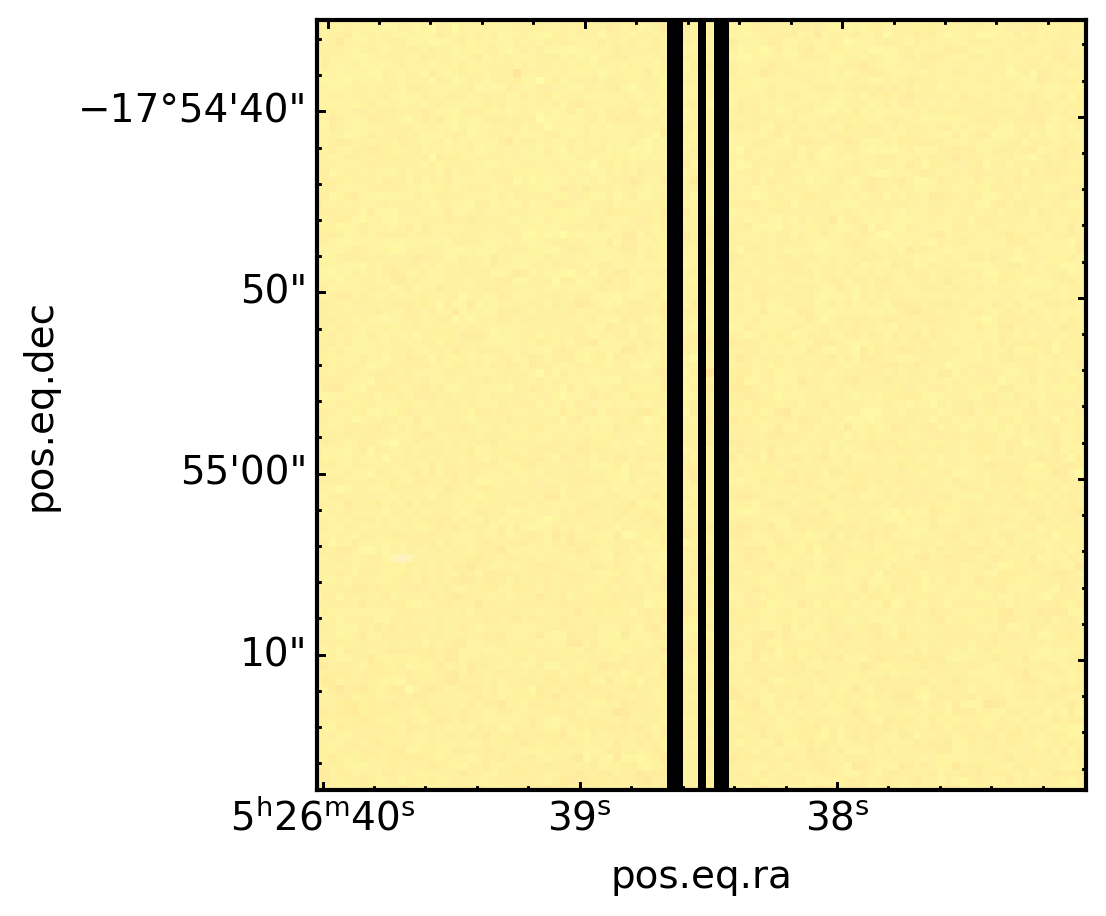

In [182]:
from astropy.visualization import make_lupton_rgb
from reproject import reproject_interp

img_dict = {img.meta["FILTER"]:img for img in wcs_data}
wcs_r = img_dict["Harris-R"].wcs # we will align everything to this WCS

img_v_reprojected, _ = reproject_interp(img_dict["Harris-V"], wcs_r)
img_b_reprojected, _ = reproject_interp(img_dict["Harris-B"], wcs_r)

color_img = make_lupton_rgb(
    img_dict["Harris-R"],
    img_v_reprojected,
    img_b_reprojected
)

fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection=wcs_r)
cax = ax.imshow(
    color_img, 
    origin="lower",
    # norm=simple_norm(
    #     data=color_img,
    #     stretch="linear",
    #     vmin=200,
    #     vmax=800
    # ),
)

ax.set_xlim(*xlim)
ax.set_ylim(*ylim)